In [1]:
import pandas as pd
import numpy as np
import re
import Levenshtein
from collections import defaultdict
import spacy
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

Step 1: Import data

In [2]:
#import mine data
#primary data
mine_full = pd.read_excel("./Data/new coal/Global-Coal-Mine-Tracker-April-2024 (1).xlsx", sheet_name="Global Coal Mine Tracker (Non-C")
#supplement data
mine_sup1_full = pd.read_excel("./Data/new coal/Global-Coal-Mine-Tracker-September-2024-Supplement-v2 (2).xlsx", sheet_name="Historical Production (non-Chin")
mine_sup2_full =pd.read_excel("./Data/new coal/Global-Coal-Mine-Tracker-December-2024-Supplement-Historical-Production-from-2018-to-2023.xlsx", sheet_name="Historical Production(non-China")

In [3]:
#import plant data
plant_full = pd.read_excel("./Data/new coal/Global-Coal-Plant-Tracker-January-2025.xlsx", sheet_name="Units")

#correct the estimated capacity with capacity factor
plant_full['Est_capacity (MW)']=plant_full['Capacity (MW)']*plant_full['Capacity factor']

#import terminal data
#note: the capacity of terminal dataset may be overestimated, because some terminals not only receive 'coal' but 'all cargo'
terminal_full = pd.read_excel("./Data/new coal/Global-Coal-Terminals-Tracker-December-2024.xlsx", sheet_name="Terminals")

Step 2: Select only operating assets

In [4]:
#mine = mine_full[mine_full['Status'] == 'Operating']
plant = plant_full[plant_full['Status'] == 'operating']
terminal = terminal_full[terminal_full['Status'] == 'Operating']

Step 3: Only keep columns that we need

In [5]:
mine = mine_full[['GEM Mine ID', 'Mine Name', 'Latitude', 'Longitude', 'Country', 'Production (Mtpa)', 'Year of Production','Status','Parent Company']]
# Plant: unit level for now
plant = plant[['GEM unit/phase ID', 'Plant name', 'Latitude', 'Longitude','Country/Area', 'Est_capacity (MW)', 'Parent']] 
# Terminal: unit level for now
terminal = terminal[['GEM Unit/Phase ID', 'Coal Terminal Name', 'Latitude', 'Longitude','Country/Area', 'Capacity (Mt)','Owner']] #there's only owner data in terminal dataset

In [6]:
# Rename the column names so they are consistent
mine.columns = ['asset_id', 'name', 'latitude', 'longitude', 'country', 'production', 'production year','status','firm']
plant.columns = ['asset_id', 'name', 'latitude', 'longitude', 'country', 'production', 'firm']
terminal.columns = ['asset_id', 'name', 'latitude', 'longitude', 'country', 'production', 'firm']

Step 4: Select Inida data

In [7]:
mine = mine[mine['country'] == 'India']
plant = plant[plant['country'] == 'India']
terminal = terminal[terminal['country'] == 'India']
mine_sup1 = mine_sup1_full[mine_sup1_full['Country'] == 'India']
mine_sup2 = mine_sup2_full[mine_sup2_full['Country'] == 'India']

Step 5: Select most recent production data for coal mine

In [8]:
# Combine 2 supplement dataset
mine_sup = pd.concat([mine_sup1, mine_sup2], ignore_index=True)
mine_sup.columns

Index(['GEM Mine ID', 'MSHA IDs', 'Country', 'Mine Name', 'Mine Name AKAs',
       'Mine Name (Non-ENG)', 'GEM Wiki Page (ENG)', 'Status',
       'Capacity (Mtpa)', 'Opening Year', 'ROM or Saleable',
       'Coal Output (Annual, Mt) 2023', 'Coal Output (Annual, Mst) 2023',
       'Output Accuracy', 'Coal Output (Annual, Mt) 2022',
       'Coal Output (Annual, Mst) 2022', 'Output Accuracy.1',
       'Coal Output (Annual, Mt) 2021', 'Coal Output (Annual, Mst) 2021',
       'Output Accuracy.2', 'Coal Output (Annual, Mt) 2020',
       'Coal Output (Annual, Mst) 2020', 'Output Accuracy.3',
       'Coal Output (Annual, Mt) 2019', 'Coal Output (Annual, Mst) 2019',
       'Output Accuracy.4', 'Coal Output (Annual, Mt) 2018',
       'Coal Output (Annual, Mst) 2018', 'Output Accuracy.5',
       'Coal Output (Annual, Mt) 2017', 'Coal Output (Annual, Mst) 2017',
       'Output Accuracy.6'],
      dtype='object')

In [9]:
# Replace '-' with NaN
mine_sup.replace('-', pd.NA, inplace=True)
# Generate column names for 'Coal Output (Annual, Mt)' from 2023 to 2017
years = list(range(2023, 2016, -1))  # List of years from 2023 to 2017
cols = [f"Coal Output (Annual, Mt) {year}" for year in years]

# Select the most recent non-null coal output value
mine_sup["Most_Recent_Coal_Output_Mt"] = mine_sup[cols].bfill(axis=1).iloc[:, 0]

# Identify the corresponding year for the selected coal output
mine_sup["Year_Selected"] = mine_sup[cols].notna().idxmax(axis=1).str.extract(r'(\d{4})')

# Convert 'Year_Selected' to integer
mine_sup["Year_Selected"] = mine_sup["Year_Selected"].astype("Int64")

In [10]:
# Keep necessary columns and rename columns
mine_sup = mine_sup[['GEM Mine ID','Most_Recent_Coal_Output_Mt','Year_Selected']]
mine_sup.columns = ['asset_id', 'production', 'production year']
mine_sup['status'] = 'Operating' # all the assets in supplement data have Operating status
mine_sup

,asset_id,production,production year,status
0,M4434,4,2023,Operating
1,M2697,3.91,2023,Operating
2,M2513,2.17,2023,Operating
3,M1722,1.32,2023,Operating
4,M0573,2.531,2022,Operating
...,...,...,...,...
348,M2859,0.32,2023,Operating
349,M6680,0.028,2023,Operating
350,M2718,0.04,2022,Operating
351,M1746,0.36,2023,Operating


In [11]:
# Merge supplement data with mine data
# Step 1: Merge mine_sup onto mine, allowing multiple production records per mine
merged = pd.concat([mine, mine_sup], ignore_index=True)

# Step 2: Sort by asset_id and production year (descending) to get the most recent data
merged = merged.sort_values(by=['asset_id', 'production year'], ascending=[True, False])

# Step 3: Group by asset_id and take the first occurrence (most recent)
mine_merged = merged.groupby('asset_id', as_index=False).first()

In [12]:
mine_merged

,asset_id,name,latitude,longitude,country,production,production year,status,firm
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,2023,Operating,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,2023,Operating,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,2023,Operating,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,2023,Operating,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,2023,Operating,Coal India Ltd [100.0%]
...,...,...,...,...,...,...,...,...,...
510,M4466,Utkal E Coal Mine,21.086237,84.872237,India,2,2023,Operating,National Aluminium Co Ltd [100%]
511,M4467,Venkatesh Khani Coal mine,17.47979,80.663705,India,*,None,Proposed,The Singareni Collieries Co Ltd [100%]
512,M4468,Bicharpur Coal Mine,23.265914,81.343859,India,0.75,2023,Operating,Aditya Birla Group
513,M6680,None,None,None,None,0.028,2023,Operating,None


In [13]:
# Filler Operating assets only
mine_merged = mine_merged[mine_merged['status'] == 'Operating']
mine_merged

,asset_id,name,latitude,longitude,country,production,production year,status,firm
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,2023,Operating,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,2023,Operating,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,2023,Operating,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,2023,Operating,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,2023,Operating,Coal India Ltd [100.0%]
...,...,...,...,...,...,...,...,...,...
507,M4463,Prakasham Khani OC Coal Mine,17.943213,80.77821,India,5.27,2023,Operating,The Singareni Collieries Co Ltd [100%]
510,M4466,Utkal E Coal Mine,21.086237,84.872237,India,2,2023,Operating,National Aluminium Co Ltd [100%]
512,M4468,Bicharpur Coal Mine,23.265914,81.343859,India,0.75,2023,Operating,Aditya Birla Group
513,M6680,None,None,None,None,0.028,2023,Operating,None


In [14]:
# Replace '*' with NaN
mine_merged.replace('*', pd.NA, inplace=True)
# Drop rows with NA
mine_merged = mine_merged.dropna()
# Drop columns are not needed
mine_final = mine_merged[['asset_id', 'name', 'latitude', 'longitude', 'country', 'production', 'firm']]

/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_63210/3752152700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mine_merged.replace('*', pd.NA, inplace=True)


In [15]:
mine_final

,asset_id,name,latitude,longitude,country,production,firm
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,18.664800,79.579000,India,1.7,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,23.790500,85.919800,India,5.35,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.807800,86.322100,India,3.14,Coal India Ltd [100.0%]
...,...,...,...,...,...,...,...
502,M4458,Pandaveswar Dalurband Coal Mine,23.697576,87.253978,India,1.08,Coal India Ltd [100.0%]
503,M4459,Parasea Belbaid Coal Mine,23.604032,87.114406,India,0.07,Coal India Ltd [100.0%]
507,M4463,Prakasham Khani OC Coal Mine,17.943213,80.778210,India,5.27,The Singareni Collieries Co Ltd [100%]
510,M4466,Utkal E Coal Mine,21.086237,84.872237,India,2,National Aluminium Co Ltd [100%]


Step 6: Combine all types of assets

In [16]:
total_data = pd.concat([mine_final, plant, terminal], ignore_index=True)

In [17]:
total_data

,asset_id,name,latitude,longitude,country,production,firm
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,Coal India Ltd [100.0%]
...,...,...,...,...,...,...,...
1233,T01164,Sikka Port Coal Terminal,22.433723,69.820199,India,3,Shree Cement
1234,T01169,Trombay Coal Terminal,18.991606,72.908227,India,2.4,Tata Group
1235,T01165,Tuna Tekra Port Coal Terminal,22.907645,70.104361,India,20,Adani Group
1236,T01176,Tuticorin Port Coal Terminal,8.756765,78.212002,India,29,V.O. Chidambaranar Port Trust


In [18]:
with pd.ExcelWriter('./Data/total_data.xlsx') as writer:
    total_data.to_excel(writer, index=False)

## Sheet 1: Assets

In [19]:
# Add the 'product' column based on 'asset_id'
total_data["product"] = total_data["asset_id"].apply(
    lambda x: "coal" if str(x).startswith(("M", "T")) else "power" if str(x).startswith("L") else None
)

In [20]:
total_data

,asset_id,name,latitude,longitude,country,production,firm,product
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,Coal India Ltd [100.0%],coal
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,The Singareni Collieries Co Ltd [100%],coal
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,Coal India Ltd [100.0%],coal
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,Coal India Ltd [100.0%],coal
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,Coal India Ltd [100.0%],coal
...,...,...,...,...,...,...,...,...
1233,T01164,Sikka Port Coal Terminal,22.433723,69.820199,India,3,Shree Cement,coal
1234,T01169,Trombay Coal Terminal,18.991606,72.908227,India,2.4,Tata Group,coal
1235,T01165,Tuna Tekra Port Coal Terminal,22.907645,70.104361,India,20,Adani Group,coal
1236,T01176,Tuticorin Port Coal Terminal,8.756765,78.212002,India,29,V.O. Chidambaranar Port Trust,coal


Before grouping all the columns, we first check if each asset has more than one unique value in the 'firm' column.

In [21]:
'''
# Group by 'asset_id' and count unique 'firm' values
df_grouped = total_data.groupby('asset_id')['firm'].nunique()

# Filter for asset_ids with more than 1 unique firm
assets_with_multiple_firms = df_grouped[df_grouped > 1].index

# Display rows where asset_id has more than 1 unique firm
df_filtered = total_data[total_data['asset_id'].isin(assets_with_multiple_firms)]
df_filtered
'''

"\n# Group by 'asset_id' and count unique 'firm' values\ndf_grouped = total_data.groupby('asset_id')['firm'].nunique()\n\n# Filter for asset_ids with more than 1 unique firm\nassets_with_multiple_firms = df_grouped[df_grouped > 1].index\n\n# Display rows where asset_id has more than 1 unique firm\ndf_filtered = total_data[total_data['asset_id'].isin(assets_with_multiple_firms)]\ndf_filtered\n"

In [22]:
'''
# Aggregate firm information for L100000102487 manually
total_data.loc[total_data['asset_id'] == 'L100000102487', 'firm'] = 'unknown [9.5%]; Essar Energy Ltd; Triton Trust; Virgo Trust; ArcelorMittal SA [30.0%]; Nippon Steel Corp [20.0%]'
'''

"\n# Aggregate firm information for L100000102487 manually\ntotal_data.loc[total_data['asset_id'] == 'L100000102487', 'firm'] = 'unknown [9.5%]; Essar Energy Ltd; Triton Trust; Virgo Trust; ArcelorMittal SA [30.0%]; Nippon Steel Corp [20.0%]'\n"

In [23]:
'''
# Group by 'asset_id' and apply aggregation
total_data_grouped = total_data.groupby("asset_id", as_index=False).agg({
    "name": "first",
    "latitude": "first",
    "longitude": "first",
    "country": "first",
    "production": "sum",
    "firm": "first",
    "product": "first"
})
'''

'\n# Group by \'asset_id\' and apply aggregation\ntotal_data_grouped = total_data.groupby("asset_id", as_index=False).agg({\n    "name": "first",\n    "latitude": "first",\n    "longitude": "first",\n    "country": "first",\n    "production": "sum",\n    "firm": "first",\n    "product": "first"\n})\n'

In [24]:
#########################################
# Using unit level for plant & terminal #
#########################################
total_data_grouped = total_data

In [25]:
total_data_grouped

,asset_id,name,latitude,longitude,country,production,firm,product
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,Coal India Ltd [100.0%],coal
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,The Singareni Collieries Co Ltd [100%],coal
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,Coal India Ltd [100.0%],coal
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,Coal India Ltd [100.0%],coal
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,Coal India Ltd [100.0%],coal
...,...,...,...,...,...,...,...,...
1233,T01164,Sikka Port Coal Terminal,22.433723,69.820199,India,3,Shree Cement,coal
1234,T01169,Trombay Coal Terminal,18.991606,72.908227,India,2.4,Tata Group,coal
1235,T01165,Tuna Tekra Port Coal Terminal,22.907645,70.104361,India,20,Adani Group,coal
1236,T01176,Tuticorin Port Coal Terminal,8.756765,78.212002,India,29,V.O. Chidambaranar Port Trust,coal


In [26]:
'''
with pd.ExcelWriter('./Data/total_data_grouped.xlsx') as writer:
    total_data_grouped.to_excel(writer, index=False)
'''

"\nwith pd.ExcelWriter('./Data/total_data_grouped.xlsx') as writer:\n    total_data_grouped.to_excel(writer, index=False)\n"

In [27]:
# Exclude the firm column
total_assets = total_data_grouped.drop(columns=['firm'])

In [28]:
total_assets

,asset_id,name,latitude,longitude,country,production,product
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,coal
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,coal
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,coal
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,coal
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,coal
...,...,...,...,...,...,...,...
1233,T01164,Sikka Port Coal Terminal,22.433723,69.820199,India,3,coal
1234,T01169,Trombay Coal Terminal,18.991606,72.908227,India,2.4,coal
1235,T01165,Tuna Tekra Port Coal Terminal,22.907645,70.104361,India,20,coal
1236,T01176,Tuticorin Port Coal Terminal,8.756765,78.212002,India,29,coal


In [29]:
# Add a new replacement_value column with NA
prod_index = total_assets.columns.get_loc('production')
total_assets.insert(prod_index, 'replacement_value', total_assets['production'] * 1740102)

In [30]:
total_assets

,asset_id,name,latitude,longitude,country,replacement_value,production,product
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,1244172.93,0.715,coal
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,2958173.4,1.7,coal
2,M0466,AKK Coal Mine,23.7905,85.9198,India,9309545.7,5.35,coal
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,5777138.64,3.32,coal
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,5463920.28,3.14,coal
...,...,...,...,...,...,...,...,...
1233,T01164,Sikka Port Coal Terminal,22.433723,69.820199,India,5220306,3,coal
1234,T01169,Trombay Coal Terminal,18.991606,72.908227,India,4176244.8,2.4,coal
1235,T01165,Tuna Tekra Port Coal Terminal,22.907645,70.104361,India,34802040,20,coal
1236,T01176,Tuticorin Port Coal Terminal,8.756765,78.212002,India,50462958,29,coal


In [31]:
# Check the number of assets
counts = total_assets['asset_id'].str.startswith(('M', 'G', 'T')).groupby(total_assets['asset_id'].str[0]).sum()
counts

asset_id
G    850
M    355
T     33
Name: asset_id, dtype: int64

In [32]:
'''
import plotly.express as px
# Define color mapping for asset_id prefixes
df_india = total_assets.copy()

color_mapping = {
    "M": "red",
    "L": "blue",
    "T": "green"
}

# Assign colors based on asset_id prefix
df_india["color"] = df_india["asset_id"].str[0].map(color_mapping).fillna("gray")

# Create Plotly scatter mapbox
fig = px.scatter_mapbox(
    df_india,
    lat="latitude",
    lon="longitude",
    text="name",
    color="color",  # Assign color
    size=[0.01] * len(df_india),  # Control marker size
    title="Indian Coal Assets Distribution",
    zoom=3,
    height=700
)

# Set the Mapbox token (replace with your own Mapbox token if needed)
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 22.3511, "lon": 78.6677},
    margin={"r": 0, "t": 50, "l": 0, "b": 0}
)

# Show figure
fig.show()
'''

'\nimport plotly.express as px\n# Define color mapping for asset_id prefixes\ndf_india = total_assets.copy()\n\ncolor_mapping = {\n    "M": "red",\n    "L": "blue",\n    "T": "green"\n}\n\n# Assign colors based on asset_id prefix\ndf_india["color"] = df_india["asset_id"].str[0].map(color_mapping).fillna("gray")\n\n# Create Plotly scatter mapbox\nfig = px.scatter_mapbox(\n    df_india,\n    lat="latitude",\n    lon="longitude",\n    text="name",\n    color="color",  # Assign color\n    size=[0.01] * len(df_india),  # Control marker size\n    title="Indian Coal Assets Distribution",\n    zoom=3,\n    height=700\n)\n\n# Set the Mapbox token (replace with your own Mapbox token if needed)\nfig.update_layout(\n    mapbox_style="carto-positron",\n    mapbox_center={"lat": 22.3511, "lon": 78.6677},\n    margin={"r": 0, "t": 50, "l": 0, "b": 0}\n)\n\n# Show figure\nfig.show()\n'

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_63210/2266329628.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


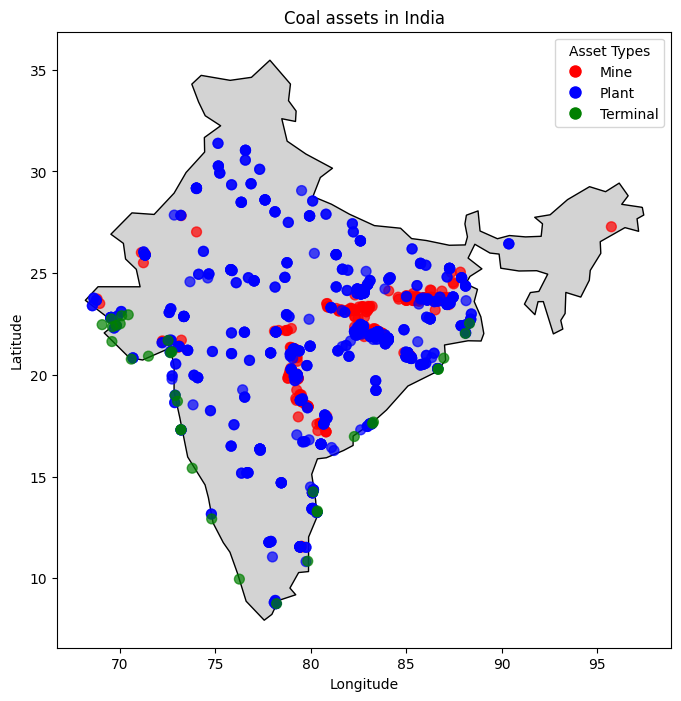

In [34]:
# Create GeoDataFrame with asset locations
gdf = gpd.GeoDataFrame(total_assets, 
                       geometry=gpd.points_from_xy(total_assets.longitude, total_assets.latitude),
                       crs="EPSG:4326")  # WGS 84 Coordinate System

# Add a new column for the color based on asset_id
gdf['color'] = gdf['asset_id'].apply(lambda x: 'red' if x.startswith('M') else ('blue' if x.startswith('G') else 'green'))

# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter to get only India
india = world[world.name == "India"]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot India's map
india.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the mine locations with different colors
gdf.plot(ax=ax, color=gdf['color'], markersize=50, alpha=0.7)

# Create custom legend
legend_labels = {
    'Mine': 'red',
    'Plant': 'blue',
    'Terminal': 'green'
}

# Create legend handles for custom legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_labels.values()]

# Add custom legend to the plot
plt.legend(handles=handles, labels=legend_labels.keys(), title="Asset Types")

# Add labels and title
plt.title("Coal assets in India")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Sheet 2 & 3: Firms & Ownership

In [35]:
total_data_grouped

,asset_id,name,latitude,longitude,country,production,firm,product
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,Coal India Ltd [100.0%],coal
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,The Singareni Collieries Co Ltd [100%],coal
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,Coal India Ltd [100.0%],coal
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,Coal India Ltd [100.0%],coal
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,Coal India Ltd [100.0%],coal
...,...,...,...,...,...,...,...,...
1233,T01164,Sikka Port Coal Terminal,22.433723,69.820199,India,3,Shree Cement,coal
1234,T01169,Trombay Coal Terminal,18.991606,72.908227,India,2.4,Tata Group,coal
1235,T01165,Tuna Tekra Port Coal Terminal,22.907645,70.104361,India,20,Adani Group,coal
1236,T01176,Tuticorin Port Coal Terminal,8.756765,78.212002,India,29,V.O. Chidambaranar Port Trust,coal


In [36]:
# Keep necessary columns
all_firms = total_data_grouped[['asset_id','name','firm']]

In [37]:
all_firms

,asset_id,name,firm
0,M0464,Adasa Coal Mine,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,Coal India Ltd [100.0%]
...,...,...,...
1233,T01164,Sikka Port Coal Terminal,Shree Cement
1234,T01169,Trombay Coal Terminal,Tata Group
1235,T01165,Tuna Tekra Port Coal Terminal,Adani Group
1236,T01176,Tuticorin Port Coal Terminal,V.O. Chidambaranar Port Trust


In [38]:
# Check NAs and add firm info manually
invalid_rows = all_firms[all_firms['firm'] == '-']
invalid_rows

,asset_id,name,firm
1218,T01182,Karaikal Port Coal Terminal,-


In [39]:
# From website https://en.wikipedia.org/wiki/Karaikal_Port, we know that APSEZ holds 100% share of Karaikal Port Coal Terminal
# Update the 'firm' value for asset_id T1182
all_firms.loc[all_firms['asset_id'] == 'T1182', 'firm'] = 'Adani Ports and Special Economic Zone Limited'

In [40]:
all_firms

,asset_id,name,firm
0,M0464,Adasa Coal Mine,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,Coal India Ltd [100.0%]
...,...,...,...
1233,T01164,Sikka Port Coal Terminal,Shree Cement
1234,T01169,Trombay Coal Terminal,Tata Group
1235,T01165,Tuna Tekra Port Coal Terminal,Adani Group
1236,T01176,Tuticorin Port Coal Terminal,V.O. Chidambaranar Port Trust


## Format firm names and extract share data

### Step 1: Seperate rows with multiple firms into different rows

In [41]:
def process_firm_name(df):
    # Step 1: Count the maximum number of delimiters (either ';' or ',')
    max_delimiters = df['firm'].str.count(r'[;,]').max()
    
    # Dynamically create column names based on the max delimiter count
    name_columns = [f'name{i+1}' for i in range(max_delimiters + 1)]

    # Split the 'firm' column by ';' or ',' into separate columns
    df[name_columns] = df['firm'].str.split(r'[;,]', expand=True, n=max_delimiters)

    # Step 2: Duplicate all other columns for each new entry
    df_expanded = df.drop(columns=['firm'])  # Drop the original 'firm' column

    # Step 3: Melt the dynamically created name columns
    df_flat = pd.melt(df_expanded, id_vars=['asset_id'], 
                      value_vars=name_columns, value_name='firm')

    # Step 4: Remove rows with NaN values in 'firm'
    df_flat = df_flat.dropna(subset=['firm'])

    # Step 5: Move 'firm' to the second column position
    df_flat.insert(1, 'firm', df_flat.pop('firm'))

    # Reset index for clean output
    df_flat.reset_index(drop=True, inplace=True)

    # Drop 'variable' column
    df_flat = df_flat.drop(columns=['variable'])

    return df_flat

# Apply the function
all_firms_flat = process_firm_name(all_firms)

/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_63210/1224347009.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name_columns] = df['firm'].str.split(r'[;,]', expand=True, n=max_delimiters)
/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_63210/1224347009.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name_columns] = df['firm'].str.split(r'[;,]', expand=True, n=max_delimiters)
/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_63210/1224347009.py:9: SettingWithCop

In [42]:
all_firms_flat

,asset_id,firm
0,M0464,Coal India Ltd [100.0%]
1,M0465,The Singareni Collieries Co Ltd [100%]
2,M0466,Coal India Ltd [100.0%]
3,M0467,Coal India Ltd [100.0%]
4,M0468,Coal India Ltd [100.0%]
...,...,...
1386,G100000101853,Housing Development Finance Corp Ltd [9.0%]
1387,G100000101852,Central Bank of India [7.7%]
1388,G100000101853,Central Bank of India [7.7%]
1389,G100000101852,State Bank of India [6.4%]


In [43]:
'''
with pd.ExcelWriter('./Data/all_firms_flat.xlsx') as writer:
    all_firms_flat.to_excel(writer, index=False)
'''

"\nwith pd.ExcelWriter('./Data/all_firms_flat.xlsx') as writer:\n    all_firms_flat.to_excel(writer, index=False)\n"

### Step 2: Extract the share data

In [44]:
def extract_percentage(firm):
    match = re.search(r'[\[\(](\d+(\.\d+)?%)[]\)]', firm)
    return match.group(1) if match else pd.NA

# Apply the function to create the new column
all_firms_flat['share'] = all_firms_flat['firm'].apply(extract_percentage)
all_firms_flat

,asset_id,firm,share
0,M0464,Coal India Ltd [100.0%],100.0%
1,M0465,The Singareni Collieries Co Ltd [100%],100%
2,M0466,Coal India Ltd [100.0%],100.0%
3,M0467,Coal India Ltd [100.0%],100.0%
4,M0468,Coal India Ltd [100.0%],100.0%
...,...,...,...
1386,G100000101853,Housing Development Finance Corp Ltd [9.0%],9.0%
1387,G100000101852,Central Bank of India [7.7%],7.7%
1388,G100000101853,Central Bank of India [7.7%],7.7%
1389,G100000101852,State Bank of India [6.4%],6.4%


In [45]:
# Check NAs in share
missing_share = all_firms_flat[all_firms_flat['share'].isna()]
missing_share

,asset_id,firm,share
354,M4468,Aditya Birla Group,NaN
377,G100000100212,Jindal Poly Investment & Finance Co Ltd,NaN
378,G100000100213,Jindal Poly Investment & Finance Co Ltd,NaN
404,G100000100280,Blackstone Inc,NaN
405,G100000100281,Blackstone Inc,NaN
...,...,...,...
1376,G100000106564,Sunrwoth Stocks Pvt Ltd,NaN
1378,G100000107806,Virgo Trust,NaN
1379,G100000107807,Virgo Trust,NaN
1380,G100000108735,Virgo Trust,NaN


For assets with completely missing share data, we assign an equal share to each. For assets with partially missing share data, we distribute the remaining share equally among the incomplete entries.

In [46]:
# Convert share to numeric (for easier calculation), replacing any '%' sign and converting to float
all_firms_flat['share'] = all_firms_flat['share'].apply(lambda x: float(str(x).replace('%', '')) if pd.notna(x) else pd.NA)

# Function to calculate the share for each asset_id with partially missing shares
def calculate_share(group):
    # Find the rows with non-missing share values
    missing_share_rows = group[group['share'].isna()]
    
    if len(missing_share_rows) > 0:
        # Calculate the remaining share to distribute (100% - known share)
        total_known_share = group['share'].sum()  # Sum of known shares
        remaining_share = 100 - total_known_share
        
        # Distribute the remaining share equally among the missing rows
        share_per_missing = remaining_share / len(missing_share_rows)
        
        # Assign the calculated share to the missing rows
        group.loc[group['share'].isna(), 'share'] = share_per_missing
    
    return group

# Group by asset_id and apply the share calculation
df = all_firms_flat.groupby('asset_id').apply(calculate_share)

# Convert share back to percentage format
df['share'] = df['share'].apply(lambda x: f"{x}%")


In [47]:
# Resetting the index to make 'asset_id' a regular column
df = df.reset_index(drop=True)
df

,asset_id,firm,share
0,G100000100034,Adani Power Ltd [100.0%],100.0%
1,G100000100041,Hindalco Industries Ltd [100.0%],100.0%
2,G100000100042,Hindalco Industries Ltd [100.0%],100.0%
3,G100000100043,Hindalco Industries Ltd [100.0%],100.0%
4,G100000100044,Hindalco Industries Ltd [100.0%],100.0%
...,...,...,...
1386,T01180,Gujarat Maritime Board,100.0%
1387,T01181,Government of India,100.0%
1388,T01182,-,100.0%
1389,T01183,Cochin Port Trust,100.0%


### Step 3: Format firm names

In [48]:
def clean_firm_names(df):
    # Remove percentage patterns inside square brackets or parentheses
    df['firm'] = df['firm'].str.replace(r'\[\d+(\.\d+)?%\]', '', regex=True)  # Remove percentage in brackets
    df['firm'] = df['firm'].str.replace(r'\(\d+(\.\d+)?%\)', '', regex=True)  # Remove percentage in parentheses
    
    # Remove the abbreviations (capital letters inside parentheses)
    df['firm'] = df['firm'].str.replace(r'\(([A-Z]+)\)', '', regex=True)  # Remove all capital letters inside parentheses
    
    # Remove a dot at the end of the name (if it exists)
    df['firm'] = df['firm'].str.replace(r'\.$', '', regex=True)
    
    # Strip any leading or trailing spaces
    df['firm'] = df['firm'].str.strip()
    
    return df

In [49]:
df = clean_firm_names(df)

In [50]:
# Function to standardize company names
def standardize_company_name(name):
    # Remove "Ltd" and "Limited"
    name = re.sub(r'\bLtd\b', '', name, flags=re.IGNORECASE)
    name = re.sub(r'\bLimited\b', '', name, flags=re.IGNORECASE)
    
    # Replace "Co" with "Company"
    name = re.sub(r'\bCo\b', 'Company', name, flags=re.IGNORECASE)
    
    # Replace "Corp" with "Corporation"
    name = re.sub(r'\bCorp\b', 'Corporation', name, flags=re.IGNORECASE)
    
    # Remove any extra spaces
    name = name.strip()
    
    return name

# Apply the function to the 'Company Name' column
df['firm'] = df['firm'].apply(standardize_company_name)

In [51]:
with pd.ExcelWriter('./Data/df2.xlsx') as writer:
    df.to_excel(writer, index=False)

In [52]:
nlp = spacy.load("en_core_web_sm")

In [53]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")
wnl = WordNetLemmatizer()

EXCLUDE_WORDS = {'alloy','authority','board','cement','coal','company','construction','corporation','development',
                 'energy','finance','generation','group','heavy','holding','inc','india','indian','industry',
                 'infrastructure','investment','iron','metal','mineral','mining','port','power','project',
                 'pvt','special','state','steel','trust','venture'}

# Function to extract words (including named entities)
def extract_words(name):
    """Extracts all words and named entities from the company name."""
    name = re.sub(r'[^a-zA-Z\s]', '', name)  # Remove special characters
    doc = nlp(name)

    name_words = set()

    for token in doc:
        if token.is_alpha:  # Ensure it's a valid word
            lemma = token.lemma_.lower()

            # Apply NLTK lemmatizer if spaCy doesn't change the word
            if lemma == token.text.lower():
                lemma = wnl.lemmatize(token.text.lower())
                
        # Exclude stopwords and common business words
        if lemma not in STOP_WORDS and lemma not in EXCLUDE_WORDS:
            name_words.add(lemma)

    return name_words

# Dictionary to store word associations
word_dict = defaultdict(set)

# Process company names
for name in df['firm']:
    words = extract_words(name)
    for word in words:
        word_dict[word].add(name)

# Output only words that appear in at least 2 different companies
for word, companies in sorted(word_dict.items()):
    if len(companies) > 1:  # Ensure word appears in at least 2 companies
        print(f"Word '{word}' found in: {', '.join(companies)}")


Word 'abu' found in: Abu Dhabi Investment Authority, Abu Dhabi National Energy Company PJSC
Word 'adani' found in: Adani Power, Adani Group
Word 'andhra' found in: The Andhra Sugars, Andhra Pradesh Power Generation Corporation, Andhra Paper
Word 'bank' found in: State Bank of India, Central Bank of India, Yes Bank
Word 'birla' found in: BK Birla Group, Birla Corporation, Aditya Birla Group
Word 'dcm' found in: DCM Shriram, DCM Shriram Industries
Word 'dhabi' found in: Abu Dhabi Investment Authority, Abu Dhabi National Energy Company PJSC
Word 'essar' found in: Essar Energy, Essar Group
Word 'gmr' found in: GMR Airports Infrastructure, GMR Power and Urban Infra, GMR Group
Word 'gujarat' found in: Gujarat Urja Vikas Nigam, Gujarat Maritime Board, Gujarat Alkalies & Chemicals, Gujarat Industries Power Company, Gujarat Mineral Development Company, State of Gujarat
Word 'home' found in: My Home Constructions Pvt, My Home Holdings Pvt
Word 'ispat' found in: Rashtriya Ispat Nigam, Godawari Po

We then match all the firm names manually, for the simplicity, we keep the parent firm name. Information is from Wikipedia and ChatGPT.

In [54]:
###########################
#  will be checked later  #
###########################

# Define the mapping
subsidiary_to_parent = {
    # abu
    # adani
    'Adani Ports and Special Economic Zone':'Adani Group', 'Adani Power':'Adani Group',
    # andhra ?
    # bank
    'Central Bank of India':'Government of India', 'State Bank of India':'Government of India',
    # birla
    'BK Birla Group':'Aditya Birla Group', # Aditya Birla Group is the successor to BK Birla Group
    # dcm
    # dhabi
    'Abu Dhabi Investment Authority':'Government of Abu Dhabi', 
    # essar
    'Essar Energy':'Essar Group',
    # gmr
    'GMR Power and Urban Infra':'GMR Group','GMR Airports Infrastructure':'GMR Group',
    # gujarat 
    'Gujarat Alkalies & Chemicals':'Government of Gujarat', 'Gujarat Mineral Development Company':'Government of Gujarat', 'Gujarat Industries Power Company':'Government of Gujarat',  'Gujarat Maritime Board':'Government of Gujarat',
    # home
    'My Home Holdings Pvt':'My Home Group','My Home Constructions Pvt':'My Home Group',
    # ispat ?
    'Corporate Ispat Alloys':'Corporate Ispat Group','Godawari Power and Ispat':'Hira Group', 
    # jaiprakash
    'Jaiprakash Power Ventures':'Jaiprakash Associates',
    # jindal
    'Jindal Power':'Jindal Group', 'Jindal Steel & Power, Jindal Stainless':'Jindal Group', 'Jindal Poly Investment & Finance Company':'Jindal Group',
    # jsw
    'JSW Projects':'JSW Group', 'JSW Steel':'JSW Group', 'JSW Ispat Special Products':'JSW Group', 'JSW Infrastructure':'JSW Group', 'JSW Energy':'JSW Group', 'JSW Holdings':'JSW Group', 'JSW Shipping & Logistics Pvt':'JSW Group',
    # national
    'National Aluminium Company':'Government of India','Abu Dhabi National Energy Company PJSC':'Government of Abu Dhabi',
    # nigam
    'Rashtriya Ispat Nigam':'Government of India',
    # paper ?
    'Andhra Paper':'International Paper', 'Sinarmas Pulp & Paper Pvt':'Asia Pulp & Paper', 'Tamil Nadu Newsprint & Papers':'Government of Tamil Nadu','JK Paper':'JK Organisation',
    # pradesh
    'Andhra Pradesh Power Generation Corporation':'Government of Andhra Pradesh', 'Madhya Pradesh Power Generating Company':'Government of Madhya Pradesh',
    # rajasthan
    'Rajasthan State Minerals and Mining':'Government of Rajasthan', 'Rajasthan State Mines and Minerals':'Government of Rajasthan','Rajasthan State Mines & Minerals':'Government of Rajasthan',
    # rajya
    # reliance
    'Reliance Infrastructure':'Reliance Industries', 'Reliance Power':'Reliance Industries',
    # shree
    # shriram
    'DCM Shriram':'DCM Shriram Group','DCM Shriram Industries':'DCM Shriram Group',
    # sugar ?
    'Shree Renuka Sugars':'Wilmar International',
    # tata
    'Tata Group':'Tata Sons','Tata Steel':'Tata Sons','Tata Power Company':'Tata Sons',
    # urja ?
    'Gujarat Urja Vikas Nigam':'Government of Gujarat',
    # utpadan
    # uttar
    # vedanta
    'Vedanta':'Vedanta Inc',
    # vidyut
    'Rajasthan Rajya Vidyut Utpadan Nigam':'Government of Rajasthan', 'Uttar Pradesh Rajya Vidyut Utpadan Nigam':'Government of Uttar Pradesh','Tenughat Vidyut Nigam':'Government of Jharkhand'
}



# Add a new 'ultimate_parent_company' column based on 'firm'
df['ultimate_parent_company'] = df['firm'].map(subsidiary_to_parent).fillna(df['firm'])


In [55]:
df

,asset_id,firm,share,ultimate_parent_company
0,G100000100034,Adani Power,100.0%,Adani Group
1,G100000100041,Hindalco Industries,100.0%,Hindalco Industries
2,G100000100042,Hindalco Industries,100.0%,Hindalco Industries
3,G100000100043,Hindalco Industries,100.0%,Hindalco Industries
4,G100000100044,Hindalco Industries,100.0%,Hindalco Industries
...,...,...,...,...
1386,T01180,Gujarat Maritime Board,100.0%,Government of Gujarat
1387,T01181,Government of India,100.0%,Government of India
1388,T01182,-,100.0%,-
1389,T01183,Cochin Port Trust,100.0%,Cochin Port Trust


In [56]:
parent_df = df.copy()

# Drop the old 'ultimate_parent_company' and 'firm' columns
parent_df = parent_df.drop(columns=['firm'])

# Rename the new column to 'firm'
parent_df = parent_df.rename(columns={'ultimate_parent_company': 'firm'})

In [57]:
parent_df

,asset_id,share,firm
0,G100000100034,100.0%,Adani Group
1,G100000100041,100.0%,Hindalco Industries
2,G100000100042,100.0%,Hindalco Industries
3,G100000100043,100.0%,Hindalco Industries
4,G100000100044,100.0%,Hindalco Industries
...,...,...,...
1386,T01180,100.0%,Government of Gujarat
1387,T01181,100.0%,Government of India
1388,T01182,100.0%,-
1389,T01183,100.0%,Cochin Port Trust


In [58]:
import random

In [59]:
# Add more columns that will be needed
def add_firms_columns(df, owner_column, seed=42):

    # Set random seed for reproducibility
    random.seed(seed)

    firms = df[[owner_column]].rename(columns={owner_column: 'name'})
    
    # Remove duplicates first
    firms = firms.drop_duplicates(subset=['name'], keep='first')

    # Adding columns
    firms['firm_id'] = pd.NA
    firms['final_demand'] = [random.choice([25, 50, 100]) for _ in range(len(firms))]
    firms['discount_rate'] = 0.05
    firms['unit_price'] = 20
    firms['margin'] = 0.02
    firms['leverage_ratio'] = 0.02
    firms['type'] = 'production'
    
    # Sort firm names alphabetically
    firms = firms.sort_values(by='name').reset_index(drop=True)

    # Assign firm_id starting from 1
    firms['firm_id'] = range(1, len(firms) + 1)

    # Adjust order of columns
    firms = firms[['firm_id', 'name', 'final_demand', 'discount_rate', 
                   'unit_price', 'margin', 'leverage_ratio', 'type']]
    
    return firms

# Apply functions
total_firms = add_firms_columns(parent_df, 'firm')


In [60]:
total_firms # 324 rows

,firm_id,name,final_demand,discount_rate,unit_price,margin,leverage_ratio,type
0,1,-,100,0.05,20,0.02,0.02,production
1,2,24R Advisory Services Pvt,25,0.05,20,0.02,0.02,production
2,3,ACB (India),50,0.05,20,0.02,0.02,production
3,4,AM Mining India Pvt,25,0.05,20,0.02,0.02,production
4,5,AM/NS,100,0.05,20,0.02,0.02,production
...,...,...,...,...,...,...,...,...
159,160,Wilmar International,50,0.05,20,0.02,0.02,production
160,161,Yes Bank,25,0.05,20,0.02,0.02,production
161,162,natural person(s),50,0.05,20,0.02,0.02,production
162,163,small shareholder(s),100,0.05,20,0.02,0.02,production


# Sheet 3: ownership

In [61]:
parent_df
ownership = parent_df.copy()

In [62]:
# Create a mapping dictionary from total_firms
firm_mapping = dict(zip(total_firms['name'], total_firms['firm_id']))

# Replace firm names with firm_id using map
ownership['firm_id'] = ownership['firm'].map(firm_mapping)
ownership.drop(columns='firm', inplace=True)
ownership['share'] = ownership['share'].str.rstrip('%').astype(float) / 100

# Check the result
ownership

,asset_id,share,firm_id
0,G100000100034,1.0,11
1,G100000100041,1.0,59
2,G100000100042,1.0,59
3,G100000100043,1.0,59
4,G100000100044,1.0,59
...,...,...,...
1386,T01180,1.0,48
1387,T01181,1.0,49
1388,T01182,1.0,1
1389,T01183,1.0,35


In [63]:
duplicates = ownership[ownership.duplicated()]

# Display duplicates
print(duplicates)

Empty DataFrame
Columns: [asset_id, share, firm_id]
Index: []


There are some conflicts that the same asset and firm have different share data, we leave it like this for now and will disuss it later

In [64]:
with pd.ExcelWriter('./Data/coal_supply_chain_india.xlsx') as writer:
    total_assets.to_excel(writer, sheet_name='assets', index=False)
    total_firms.to_excel(writer, sheet_name='firms', index=False)
    ownership.to_excel(writer, sheet_name='ownership', index=False)